In [9]:
import re
import random
import pathlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from spacy.compat import pickle

!pip install cytoolz

import cytoolz

SPACY_CORE_MODEL = 'es_core_news_md'
spacy.cli.download(SPACY_CORE_MODEL)

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_md')


In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime/data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Sentime/data


In [0]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def read_data(data_dir, title, limit=0):
    dataset = pd.read_csv(data_dir / 'data.csv')

    categories_count = dataset['sentiment'].value_counts()
    print(categories_count)

    fig = plt.figure(figsize=(10, 10))
    sns.barplot(x=categories_count.index, y=categories_count)
    plt.title(title)
    plt.show()

    dataset = dataset[dataset['sentiment'] != 'MIXED']
    # dataset = dataset[dataset['sentiment'] != 'NEUTRAL']

    tweets = [str(tweet) for tweet in dataset['tweet']]

    sentiments = LabelEncoder()
    sentiments = sentiments.fit_transform(dataset['sentiment'])
    sentiments = to_categorical(sentiments)

    examples = zip(tweets, sentiments)
    examples = list(examples)

    if limit >= 1:
      examples = examples[:limit]

    return zip(*examples)  # Unzips into two lists

def get_labelled_sentences(docs, doc_labels):
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        for sent in doc.sents:
            sentences.append(sent)
            labels.append(y)
    return sentences, np.asarray(labels, dtype='f')

def get_features(docs, max_length):
    docs = list(docs)
    Xs = np.zeros((len(docs), max_length))
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [0]:
batch_size=128

class SentimentAnalyser():
    @staticmethod
    def get_embeddings(vocab):
      return vocab.vectors.data

    @classmethod
    def load(cls, nlp, model, lstm_weights, max_length=140):
      embeddings = cls.get_embeddings(nlp.vocab)
      model.set_weights([embeddings] + lstm_weights)
      return cls(model, max_length=max_length)

    @classmethod
    def predict(cls, nlp, texts):
      docs = nlp.pipe(texts, batch_size=batch_size)
      return [doc.sentiment for doc in docs]

    def __init__(self, model, max_length=140):
      self._model = model
      self.max_length = max_length

    def __call__(self, doc):
      X = get_features([doc], self.max_length)
      y = self._model.predict(X)
      self.set_sentiment(doc, y)

    def pipe(self, docs, batch_size=batch_size):
      for minibatch in cytoolz.partition_all(batch_size, docs):
          minibatch = list(minibatch)
          sentences = []
          for doc in minibatch:
              sentences.extend(doc.sents)
          Xs = get_features(sentences, self.max_length)
          ys = self._model.predict(Xs)
          for sent, label in zip(sentences, ys):
              sent.doc.sentiment += np.argmax(label) - 1
          for doc in minibatch:
              yield doc

    def set_sentiment(self, doc, y):
      doc.sentiment = y
      # Sentiment has a native slot for a single float.
      # For arbitrary data storage, there's:
      # doc.user_data['my_data'] = y

Read data
NEUTRAL     25761
POSITIVE    22123
NEGATIVE    14459
MIXED        4854
Name: sentiment, dtype: int64


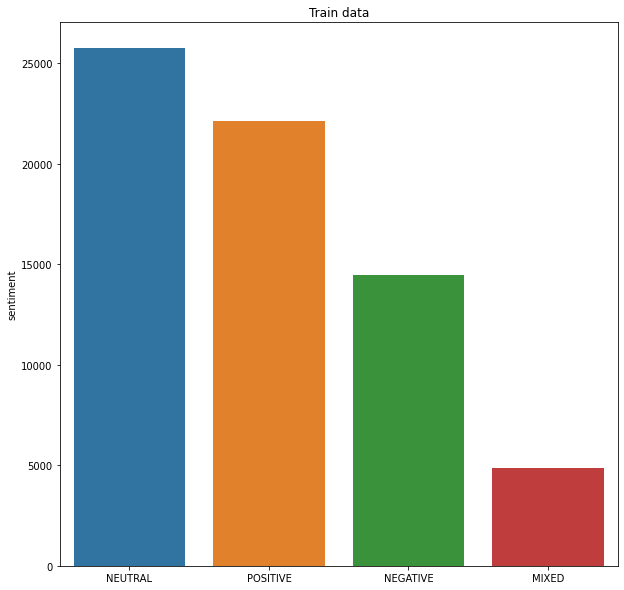

NEUTRAL     4313
POSITIVE    4242
NEGATIVE    3022
MIXED       1021
Name: sentiment, dtype: int64


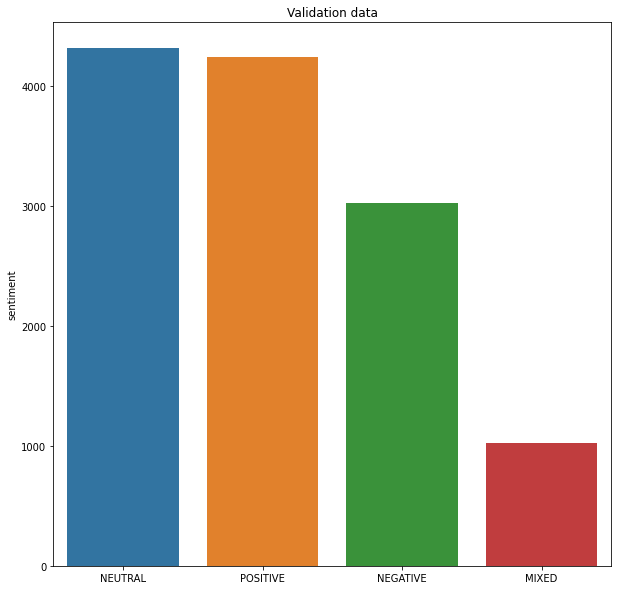

Loading spaCy


In [14]:
model_dir=pathlib.Path('model') # Location of output model directory
train_dir=pathlib.Path('train') # Location of training file or directory
val_dir=pathlib.Path('validation') # Location of development file or directory

print("Read data")
train_texts, train_labels = read_data(train_dir, title="Train data")
val_texts, val_labels = read_data(val_dir, title="Validation data")

train_labels = np.asarray(train_labels, dtype='f')
val_labels = np.asarray(val_labels, dtype='f')

print("Loading spaCy")
nlp = spacy.load(SPACY_CORE_MODEL)
nlp.add_pipe(nlp.create_pipe("sentencizer"))

In [0]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional
from keras.layers import Conv1D, Flatten, MaxPooling1D, Dropout
from keras.optimizers import Adam

shape = {
    "nr_hidden": 64,
    "conv_filters": 54,
    "conv_kernel": 5,
    "pool_size": 2,
    "max_length": 140,
    "nr_class": 3
}
settings = {
    "dropout": 0.5,
    "lr": 0.001,
    "nb_epoch": 10,
    "batch_size": batch_size,
}
embeddings = SentimentAnalyser.get_embeddings(nlp.vocab)

model = Sequential()
model.add(
    Embedding(
        embeddings.shape[0],
        embeddings.shape[1],
        input_length=shape["max_length"],
        trainable=True,
        weights=[embeddings],
        mask_zero=True
    )
)
#model.add(
#    Conv1D(
#        filters=shape["conv_filters"],
#        kernel_size=shape["conv_kernel"],
#        activation='relu',
#        padding='causal'
#    )
#)
# model.add(MaxPooling1D(pool_size=shape["pool_size"]))
model.add(
    Bidirectional(
        LSTM(
            shape["nr_hidden"],
            recurrent_dropout=settings["dropout"],
            dropout=settings["dropout"],
        )
    )
)
model.add(Dense(shape["nr_class"], activation="softmax"))
model.compile(
    optimizer=Adam(lr=settings["lr"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [16]:
train_docs = list(nlp.pipe(train_texts))
val_docs = list(nlp.pipe(val_texts))

train_docs, train_labels = get_labelled_sentences(train_docs, train_labels)
val_docs, val_labels = get_labelled_sentences(val_docs, val_labels)

train_X = get_features(train_docs, shape["max_length"])
val_X = get_features(val_docs, shape["max_length"])

history = model.fit(
    train_X,
    train_labels,
    validation_data=(val_X, val_labels),
    epochs=settings["nb_epoch"],
    batch_size=settings["batch_size"],
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70189 samples, validate on 13026 samples
Epoch 1/10
70189/70189 [==============================] - 404s 6ms/step - loss: 0.8600 - accuracy: 0.5989 - val_loss: 0.7332 - val_accuracy: 0.6802
Epoch 2/10
70189/70189 [==============================] - 399s 6ms/step - loss: 0.7208 - accuracy: 0.6847 - val_loss: 0.6682 - val_accuracy: 0.7124
Epoch 3/10
70189/70189 [==============================] - 400s 6ms/step - loss: 0.6596 - accuracy: 0.7170 - val_loss: 0.6562 - val_accuracy: 0.7197
Epoch 4/10
70189/70189 [==============================] - 390s 6ms/step - loss: 0.6222 - accuracy: 0.7358 - val_loss: 0.6474 - val_accuracy: 0.7269
Epoch 5/10
70189/70189 [==============================] - 398s 6ms/step - loss: 0.5930 - accuracy: 0.7476 - val_loss: 0.6490 - val_accuracy: 0.7253
Epoch 6/10
70189/70189 [==============================] - 395s 6ms/step - loss: 0.5685 - accuracy: 0.7598 - val_loss: 0.6536 - val_accuracy: 0.7226
Epoch 7/10
70189/70189 [==============================] - 388s

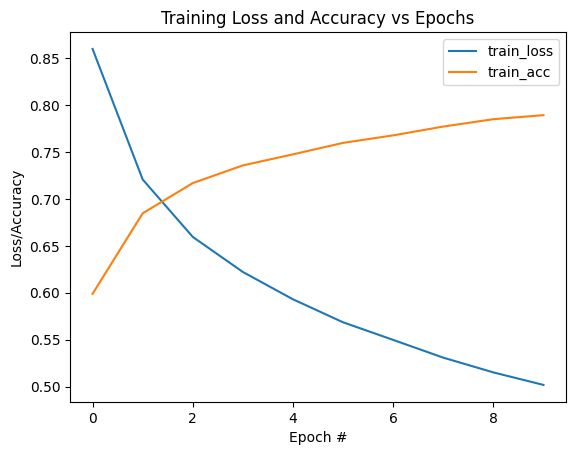

In [23]:
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.title('Training Loss and Accuracy vs Epochs')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='best')

In [0]:
# Save model
weights = model.get_weights()

if model_dir is not None:
    with (model_dir / "model").open("wb") as file_:
        pickle.dump(weights[1:], file_)
    with (model_dir / "config.json").open("w") as file_:
        file_.write(model.to_json())

NEUTRAL     1822
POSITIVE    1082
NEGATIVE    1041
MIXED        255
Name: sentiment, dtype: int64


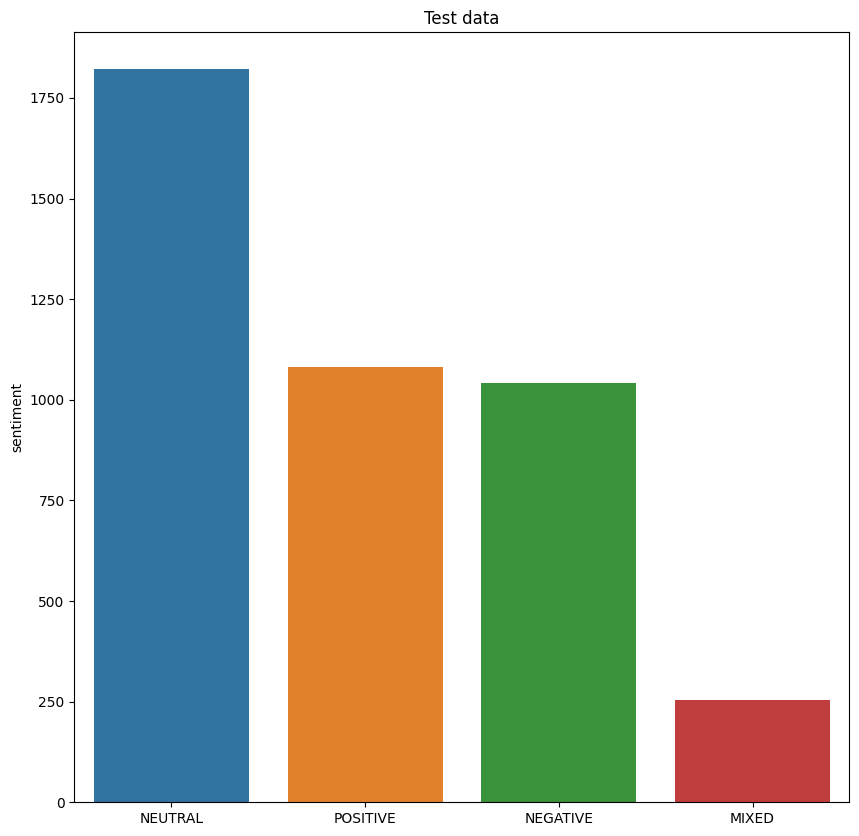

Test accuracy: 0.6435091277890467


In [25]:
# Evaluate
evaluate_nlp = spacy.load(SPACY_CORE_MODEL)
evaluate_nlp.add_pipe(evaluate_nlp.create_pipe("sentencizer"))
evaluate_nlp.add_pipe(SentimentAnalyser.load(evaluate_nlp, model, weights[1:]))

test_texts, test_labels = read_data(pathlib.Path('test'), title="Test data")

predictions = SentimentAnalyser.predict(evaluate_nlp, test_texts)
correct = 0
for i, prediction in enumerate(predictions):
    correct += prediction == np.argmax(test_labels[i]) - 1

print("Test accuracy: {}".format(float(correct) / i))